In [2]:
import os
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as md

In [3]:
# to disable GPU support
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# fix/hack for CUDA: https://github.com/tensorflow/tensorflow/issues/41987
#                    https://www.gitmemory.com/issue/tensorflow/tensorflow/41993/668082420
os.environ['TF_CUDNN_RESET_RND_GEN_STATE'] = '1'

# code inspired from:
# 1. https://www.kaggle.com/mineshjethva/timeseries-anomaly-detection-using-rnn-autoencoder/comments
# 2. https://www.kaggle.com/koheimuramatsu/industrial-machine-anomaly-detection

# 1. Read Raw Data

## 1.1. Artificial Data

In [6]:
url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
small_noise_url = url_root + small_noise_url_suffix
df_small_noise = pd.read_csv(small_noise_url)

daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
daily_jumpsup_url = url_root + daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(daily_jumpsup_url)

## 1.2. Real Data

In [8]:
aws_url_suffix = "realKnownCause/ec2_request_latency_system_failure.csv"
aws_latency_data_url = url_root + aws_url_suffix
df_aws_latency = pd.read_csv(aws_latency_data_url)

# 4. Use Statistics to Detect Anomalies

## 4.1. Median Absolute Deviation

### 4.1.1. Artificial Data

In [16]:
median_a = df_daily_jumpsup.value.median()

In [17]:
print(median_a)

21.64850265575


In [18]:
mad_a = df_daily_jumpsup.value.mad()

In [19]:
print(mad_a)

29.240658123207023


In [21]:
anomalies_mad_a = df_daily_jumpsup[abs(df_daily_jumpsup.value - median_a) > mad_a]

In [22]:
anomalies_mad_a_mask = abs(df_daily_jumpsup.value - median_a) > mad_a

In [24]:
anomalies_mad_a.describe()

,value
count,1512.000000
mean,83.470635
std,18.798566
min,61.234296
25%,74.641558
50%,79.551611
75%,84.374652
max,164.947481


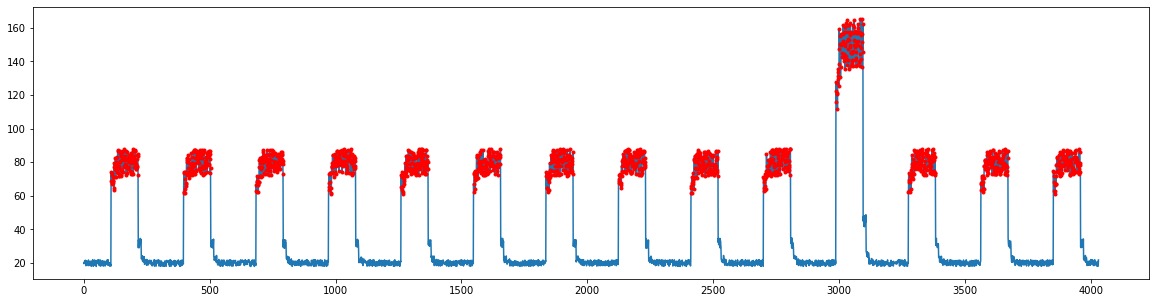

In [26]:
fig, ax = plt.subplots()

ax = df_daily_jumpsup.value.plot(figsize=(20,5))
ax = df_daily_jumpsup.loc[anomalies_mad_a_mask].value.plot(figsize=(20,5), color='red', marker='.', linestyle='none')

plt.show()

### 4.1.2. Real Data

In [27]:
median_r = df_aws_latency.value.median()

In [28]:
mad_r = df_aws_latency.value.mad()

In [29]:
print(median_r)

45.01700000000001


In [30]:
print(mad_r)

1.557677679014314


In [31]:
anomalies_mad_r = df_aws_latency[abs(df_aws_latency.value - median_r) > mad_r]
anomalies_mad_r_mask = abs(df_aws_latency.value - median_r) > mad_r
anomalies_mad_r.describe()

,value
count,1584.000000
mean,45.405559
std,3.481986
min,22.864000
25%,42.746000
50%,46.738000
75%,47.634000
max,99.248000


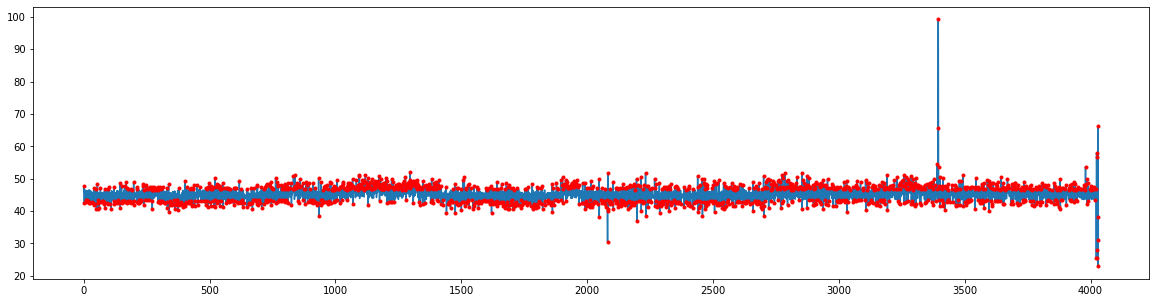

In [32]:
fig, ax = plt.subplots()

ax = df_aws_latency.value.plot(figsize=(20,5))
ax = df_aws_latency.loc[anomalies_mad_r_mask].value.plot(figsize=(20,5), color='red', marker='.', linestyle='none')

plt.show()

## 4.2. Interquartile Range

In [33]:
q1_a = df_daily_jumpsup.value.quantile(q=0.25)

In [34]:
q3_a = df_daily_jumpsup.value.quantile(q=0.75)

In [35]:
iqr_a = q3_a - q1_a

In [36]:
l_threshold_a = q1_a - 1.5 * iqr_a

In [37]:
h_threshold_a = q3_a + 1.5 * iqr_a

In [38]:
print('Q1={}, Q3={}, IQR={}, L_THR={}, H_THR={}'.format(q1_a, q3_a, iqr_a, l_threshold_a, h_threshold_a))

Q1=19.99138176275, Q3=76.43594258925, IQR=56.44456082650001, L_THR=-64.67545947700002, H_THR=161.10278382900003


In [39]:
anomalies_iqr_a = df_daily_jumpsup[df_daily_jumpsup.value > h_threshold_a]

In [40]:
anomalies_iqr_a_mask = df_daily_jumpsup.value > h_threshold_a

In [41]:
anomalies_iqr_a.describe()

,value
count,12.000000
mean,162.888561
std,1.439290
min,161.349096
25%,161.719147
50%,162.331918
75%,164.436694
max,164.947481


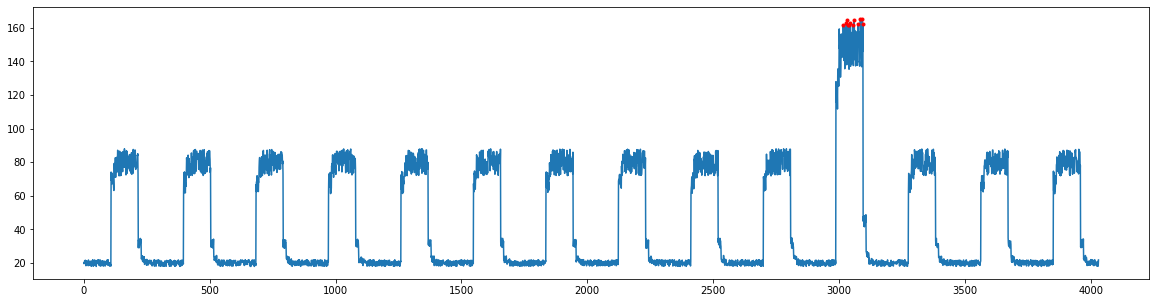

In [42]:
fig, ax = plt.subplots()

ax = df_daily_jumpsup.value.plot(figsize=(20,5))
ax = df_daily_jumpsup.loc[anomalies_iqr_a_mask].value.plot(figsize=(20,5), color='red', marker='.', linestyle='none')

plt.show()

### 4.2.2. Real Data

In [43]:
q1_r = df_aws_latency.value.quantile(q=0.25)

In [44]:
q3_r = df_aws_latency.value.quantile(q=0.75)

In [45]:
iqr_r = q3_r - q1_r

In [46]:
l_threshold_r = q1_r - 1.5 * iqr_r

In [47]:
h_threshold_r = q3_r + 1.5 * iqr_r

In [48]:
print('Q1={}, Q3={}, IQR={}, L_THR={}, H_THR={}'.format(q1_r, q3_r, iqr_r, l_threshold_r, h_threshold_r))

Q1=43.944, Q3=46.362, IQR=2.4179999999999993, L_THR=40.31700000000001, H_THR=49.989000000000004


In [49]:
anomalies_iqr_r = df_aws_latency[df_aws_latency.value > h_threshold_r]

In [50]:
anomalies_iqr_r_mask = (df_aws_latency.value > h_threshold_r) | (df_aws_latency.value < l_threshold_r)

In [51]:
anomalies_iqr_r.describe()

,value
count,52.000000
mean,52.618846
std,7.362596
min,50.000000
25%,50.200500
50%,50.730000
75%,51.298500
max,99.248000


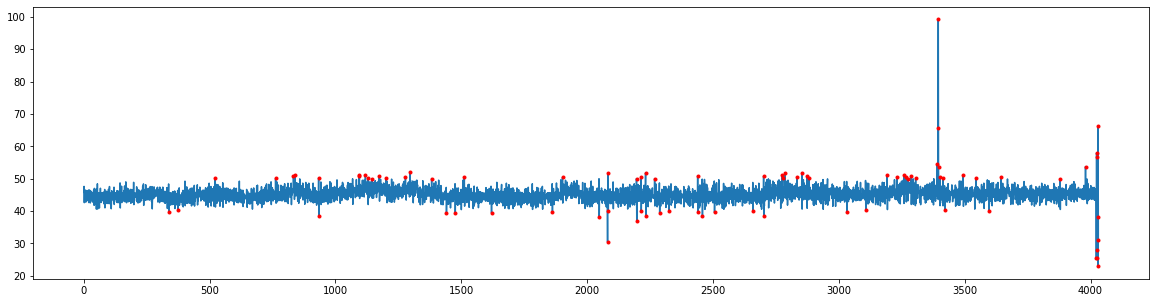

In [52]:
fig, ax = plt.subplots()

ax = df_aws_latency.value.plot(figsize=(20,5))
ax = df_aws_latency.loc[anomalies_iqr_r_mask].value.plot(figsize=(20,5), color='red', marker='.', linestyle='none')

plt.show()

## 4.3. Z-Score

### 4.3.1. Artificial Data

In [54]:
df_daily_jumpsup_copy = df_daily_jumpsup.copy()

In [55]:
std = df_daily_jumpsup_copy.value.std()

In [56]:
mean = df_daily_jumpsup_copy.value.mean()

In [57]:
df_daily_jumpsup_copy['z'] = (df_daily_jumpsup_copy.value - mean) / std

<AxesSubplot:>

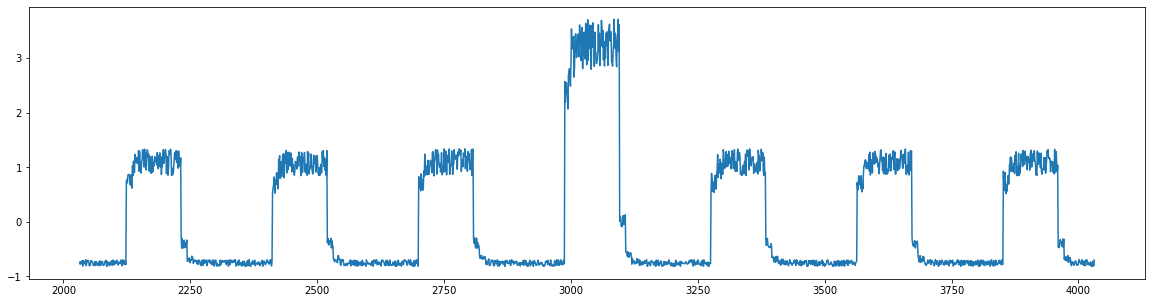

In [58]:
df_daily_jumpsup_copy.tail(2000).z.plot(figsize=(20,5))

In [59]:
z_threshold = 2.5

In [60]:
anomalies_z_a = df_daily_jumpsup_copy[df_daily_jumpsup_copy.z > z_threshold]

In [61]:
anomalies_z_a_mask = df_daily_jumpsup.value > z_threshold

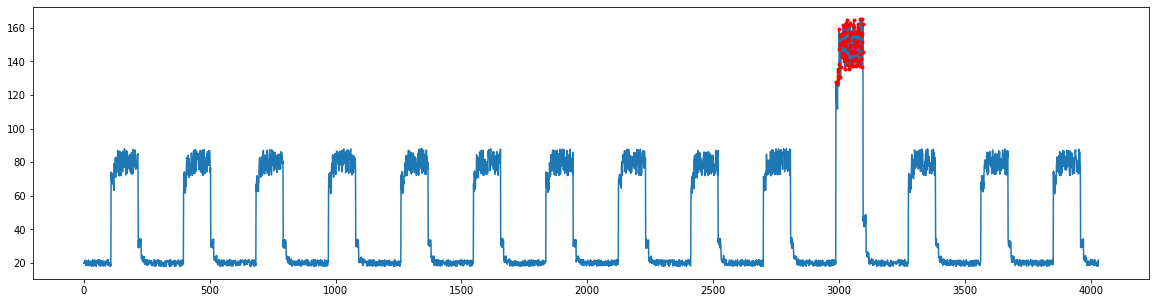

In [62]:
fig, ax = plt.subplots()

ax = df_daily_jumpsup_copy.value.plot(figsize=(20,5))
ax = anomalies_z_a.loc[anomalies_z_a_mask].value.plot(figsize=(20,5), color='red', marker='.', linestyle='none')

plt.show()

### 4.3.2. Real Data

In [63]:
df_aws_latency_copy = df_aws_latency.copy()

In [64]:
std = df_aws_latency_copy.value.std()

In [65]:
mean = df_aws_latency_copy.value.mean()

In [66]:
df_aws_latency_copy['z'] = (df_aws_latency_copy.value - mean) / std

In [67]:
z_threshold_r = 2.5

In [68]:
anomalies_z_r = df_aws_latency_copy[df_aws_latency_copy.z > z_threshold_r]

In [69]:
anomalies_z_r_mask = df_aws_latency_copy.value > z_threshold

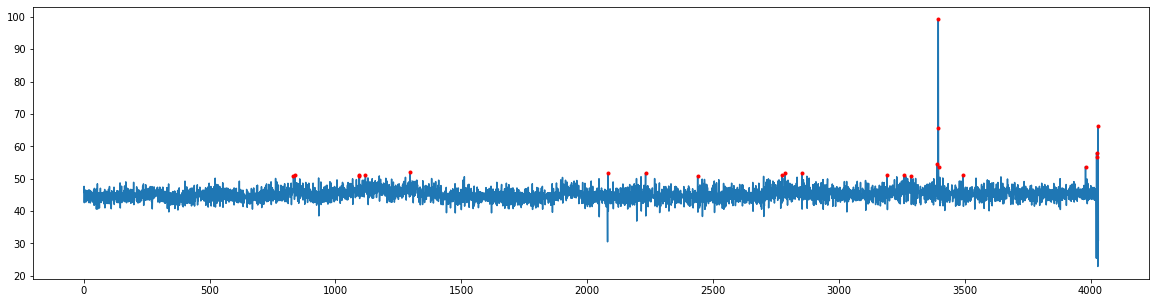

In [70]:
fig, ax = plt.subplots()

ax = df_aws_latency_copy.value.plot(figsize=(20,5))
ax = anomalies_z_r.loc[anomalies_z_r_mask].value.plot(figsize=(20,5), color='red', marker='.', linestyle='none')

plt.show()

In [71]:
# AWS "realKnownCause/ec2_request_latency_system_failure.csv"
# data from: https://github.com/numenta/NAB/blob/master/labels/combined_windows.json
anomalies_aws = [
    [
        "2014-03-14 03:31:00.000000",
        "2014-03-14 14:41:00.000000"
    ],
    [
        "2014-03-18 17:06:00.000000",
        "2014-03-19 04:16:00.000000"
    ],
    [
        "2014-03-20 21:26:00.000000",
        "2014-03-21 03:41:00.000000"
    ]
]

In [72]:
mask_aws_latency_anomaly1 = (df_aws_latency_copy['timestamp'] > anomalies_aws[0][0]) & (df_aws_latency_copy['timestamp'] <= anomalies_aws[0][1])
mask_aws_latency_anomaly2 = (df_aws_latency_copy['timestamp'] > anomalies_aws[1][0]) & (df_aws_latency_copy['timestamp'] <= anomalies_aws[1][1])
mask_aws_latency_anomaly3 = (df_aws_latency_copy['timestamp'] > anomalies_aws[2][0]) & (df_aws_latency_copy['timestamp'] <= anomalies_aws[2][1])

In [73]:
print(np.sum(mask_aws_latency_anomaly1))
print(np.sum(mask_aws_latency_anomaly2))
print(np.sum(mask_aws_latency_anomaly3))

134
134
75


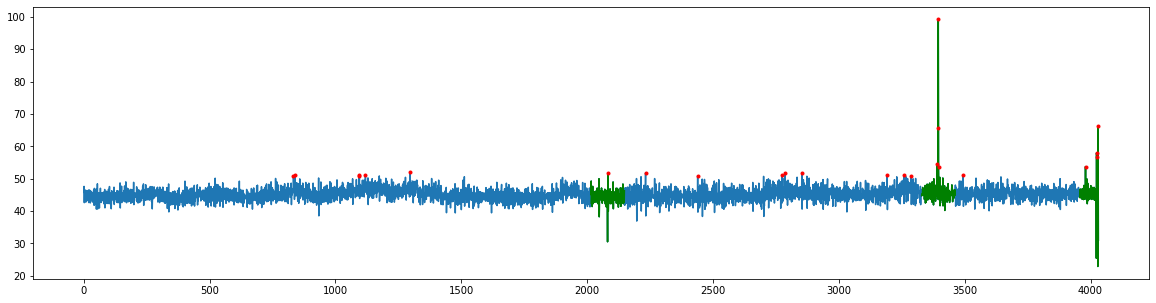

In [74]:
fig, ax = plt.subplots()

ax = df_aws_latency_copy.value.plot(figsize=(20,5))
ax = df_aws_latency_copy.loc[mask_aws_latency_anomaly1].value.plot(figsize=(20,5), color='green')
ax = df_aws_latency_copy.loc[mask_aws_latency_anomaly2].value.plot(figsize=(20,5), color='green')
ax = df_aws_latency_copy.loc[mask_aws_latency_anomaly3].value.plot(figsize=(20,5), color='green')
ax = anomalies_z_r.loc[anomalies_z_r_mask].value.plot(figsize=(20,5), color='red', marker='.', linestyle='none')

plt.show()

## 4.4. Histogram

### 4.4.1. Artificial Data

<AxesSubplot:>

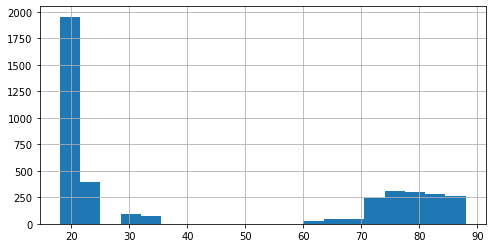

In [75]:
df_small_noise.value.hist(bins=20, figsize=(16,4))

<AxesSubplot:>

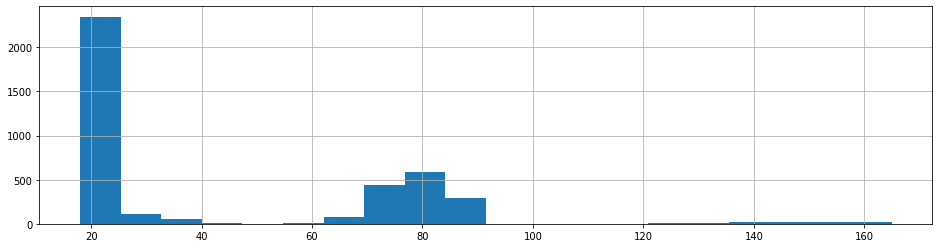

In [76]:
df_daily_jumpsup.value.hist(bins=20, figsize=(16,4))

In [77]:
anomalies_histogram = df_daily_jumpsup[df_daily_jumpsup.value > 120]

In [78]:
anomalies_z_a_mask = df_daily_jumpsup.value > 120

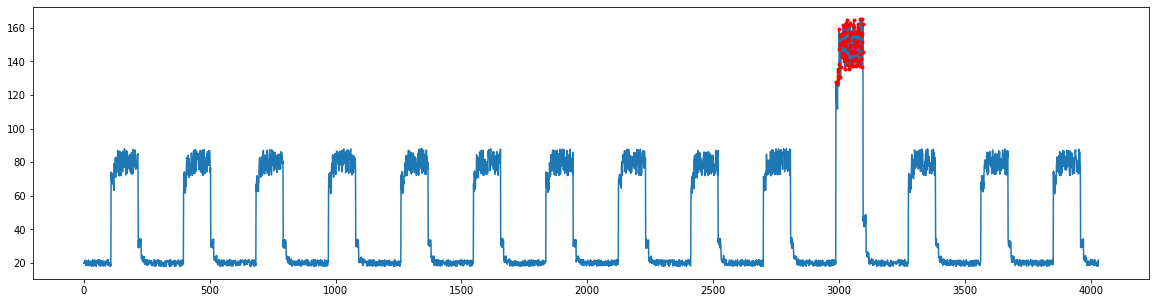

In [79]:
fig, ax = plt.subplots()

ax = df_daily_jumpsup_copy.value.plot(figsize=(20,5))
ax = anomalies_z_a.loc[anomalies_z_a_mask].value.plot(figsize=(20,5), color='red', marker='.', linestyle='none')

plt.show()

### 4.4.2. Real Data

<AxesSubplot:>

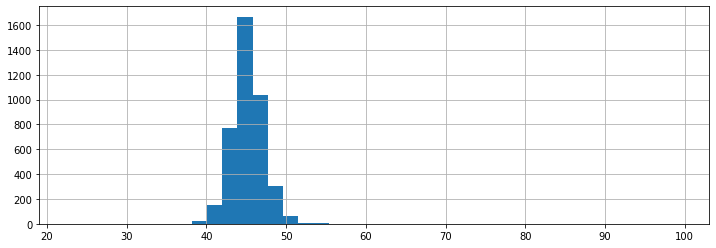

In [80]:
df_aws_latency.value.hist(bins=40, figsize=(12,4))

# 5. Deep-Learning Approach

## 5.1. Prepare Data

In [81]:
def get_values_from_df(df):
    return df.value.to_list()

In [82]:
def normalize(values):
    mean = np.mean(values)
    values -= mean
    std = np.std(values)
    values /= std
    return values, mean, std

In [83]:
# select values that are not part of anomalous areas
df_aws_latency_train = df_aws_latency_copy.loc[~mask_aws_latency_anomaly1 & 
                                               ~mask_aws_latency_anomaly2 & 
                                               ~mask_aws_latency_anomaly3]

In [84]:
# Get the `value` column from the training dataframe.
training_values_a = get_values_from_df(df_small_noise)
training_values_r = get_values_from_df(df_aws_latency_train)

In [85]:
# Normalize `value` and save the mean and std we get,
# for normalizing test data.
training_values_a, training_mean_a, training_std_a = normalize(training_values_a)
training_values_r, training_mean_r, training_std_r = normalize(training_values_r)

In [86]:
print(len(training_values_a))
print(len(training_values_r))

4032
3689


<AxesSubplot:>

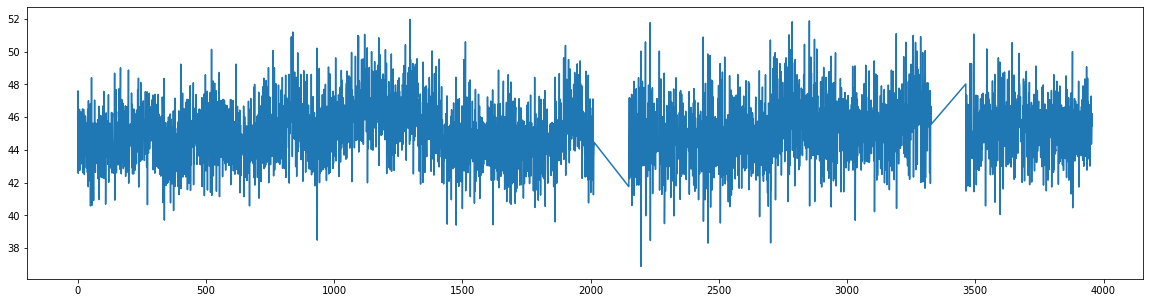

In [87]:
df_aws_latency_train.value.plot(figsize=(20,5))

## 5.2. Prepare sequences

In [88]:
TIME_STEPS_A = 288
TIME_STEPS_R = 134

In [89]:
def create_sequences(values, time_steps):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    # Convert 2D sequences into 3D as we will be feeding this into
    # a convolutional layer.
    return np.expand_dims(output, axis=2)

In [90]:
x_train_a = create_sequences(training_values_a, time_steps=TIME_STEPS_A)
x_train_r = create_sequences(training_values_r, time_steps=TIME_STEPS_R)

In [91]:
print("Training input shape artificial: ", x_train_a.shape)
print("Training input shape real: ", x_train_r.shape)

Training input shape artificial:  (3744, 288, 1)
Training input shape real:  (3555, 134, 1)


## 5.3. Build Models

In [92]:
def create_model(n_steps, n_features, learning_rate=0.001, kernel_size=15, units=25):
    keras.backend.clear_session()
    model = keras.Sequential(
        [
            layers.InputLayer(input_shape=(n_steps, n_features)),
            layers.Conv1D(filters=32, 
                          kernel_size=kernel_size, 
                          padding='same', 
                          data_format='channels_last',
                          dilation_rate=1, 
                          activation="linear"),
            layers.LSTM(units=units, activation="tanh", name="lstm_1", return_sequences=False),
            layers.RepeatVector(n_steps),
            layers.LSTM(units=units, activation="tanh", name="lstm_2", return_sequences=True),
            layers.Conv1D(filters=32, 
                          kernel_size=kernel_size, 
                          padding='same', 
                          data_format='channels_last',
                          dilation_rate=1, 
                          activation="linear"),
            layers.TimeDistributed(layers.Dense(1, activation='linear'))
        ]
    )
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
    model.summary()
    return model

### 5.3.1. Artificial Data

In [93]:
n_steps_a = x_train_a.shape[1]
n_features_a = x_train_a.shape[2]

In [94]:
# create model based on artificial data
model_a = create_model(n_steps_a, n_features_a)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 288, 32)           512       
_________________________________________________________________
lstm_1 (LSTM)                (None, 25)                5800      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 288, 25)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 288, 25)           5100      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 288, 32)           12032     
_________________________________________________________________
time_distributed (TimeDistri (None, 288, 1)            33        
Total params: 23,477
Trainable params: 23,477
Non-trainable params: 0
____________________________________________________

### 5.3.2. Real Data

In [96]:
n_steps_r = x_train_r.shape[1]
n_features_r = x_train_r.shape[2]

In [97]:
# create model based on real data
model_r = create_model(n_steps_r, n_features_r, learning_rate=0.01, kernel_size=30, units=50)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 134, 32)           992       
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                16600     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 134, 50)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 134, 50)           20200     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 134, 32)           48032     
_________________________________________________________________
time_distributed (TimeDistri (None, 134, 1)            33        
Total params: 85,857
Trainable params: 85,857
Non-trainable params: 0
____________________________________________________

## 5.4. Train Models

In [98]:
def train_model(model, x_train, batch_size=128, patience=50, epochs=200):
    """ use x_train as both the input and the target since this is a reconstruction model. """
    history = model.fit(
        x_train,
        x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.1,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor="val_loss", 
                                          patience=patience, 
                                          mode="min", 
                                          restore_best_weights=True)
        ],
    )
    return history

### 5.4.1. Artificial Data

In [100]:
history_a = train_model(model_a, x_train_a, batch_size=64)

Epoch 1/200
53/53 [==============================] - 1s 27ms/step - loss: 0.5112 - val_loss: 0.4556
Epoch 2/200
53/53 [==============================] - 1s 23ms/step - loss: 0.5526 - val_loss: 0.5484
Epoch 3/200
53/53 [==============================] - 1s 24ms/step - loss: 0.5698 - val_loss: 0.5630
Epoch 4/200
53/53 [==============================] - 1s 24ms/step - loss: 0.4732 - val_loss: 0.4000
Epoch 5/200
53/53 [==============================] - 1s 24ms/step - loss: 0.4573 - val_loss: 0.4452
Epoch 6/200
53/53 [==============================] - 1s 24ms/step - loss: 0.5566 - val_loss: 0.4795
Epoch 7/200
53/53 [==============================] - 1s 24ms/step - loss: 0.5035 - val_loss: 0.5975
Epoch 8/200
53/53 [==============================] - 1s 24ms/step - loss: 0.5586 - val_loss: 0.5585
Epoch 9/200
53/53 [==============================] - 1s 24ms/step - loss: 0.5273 - val_loss: 0.4491
Epoch 10/200
53/53 [==============================] - 1s 23ms/step - loss: 0.5200 - val_loss: 0.5135

53/53 [==============================] - 1s 24ms/step - loss: 0.0477 - val_loss: 0.0422
Epoch 83/200
53/53 [==============================] - 1s 23ms/step - loss: 0.0494 - val_loss: 0.0618
Epoch 84/200
53/53 [==============================] - 1s 24ms/step - loss: 0.0495 - val_loss: 0.0411
Epoch 85/200
53/53 [==============================] - 1s 24ms/step - loss: 0.0483 - val_loss: 0.0410
Epoch 86/200
53/53 [==============================] - 1s 24ms/step - loss: 0.0420 - val_loss: 0.0408
Epoch 87/200
53/53 [==============================] - 1s 23ms/step - loss: 0.0431 - val_loss: 0.0398
Epoch 88/200
53/53 [==============================] - 1s 23ms/step - loss: 0.0427 - val_loss: 0.0446
Epoch 89/200
53/53 [==============================] - 1s 24ms/step - loss: 0.0435 - val_loss: 0.0390
Epoch 90/200
53/53 [==============================] - 1s 23ms/step - loss: 0.0433 - val_loss: 0.0393
Epoch 91/200
53/53 [==============================] - 1s 24ms/step - loss: 0.0393 - val_loss: 0.0348
Epo

53/53 [==============================] - 1s 23ms/step - loss: 0.0313 - val_loss: 0.0289
Epoch 163/200
53/53 [==============================] - 1s 23ms/step - loss: 0.0324 - val_loss: 0.0426
Epoch 164/200
53/53 [==============================] - 1s 24ms/step - loss: 0.0467 - val_loss: 0.0344
Epoch 165/200
53/53 [==============================] - 1s 23ms/step - loss: 0.0417 - val_loss: 0.0399
Epoch 166/200
53/53 [==============================] - 1s 23ms/step - loss: 0.0351 - val_loss: 0.0298
Epoch 167/200
53/53 [==============================] - 1s 24ms/step - loss: 0.0302 - val_loss: 0.0271
Epoch 168/200
53/53 [==============================] - 1s 23ms/step - loss: 0.0316 - val_loss: 0.0434
Epoch 169/200
53/53 [==============================] - 1s 23ms/step - loss: 0.0322 - val_loss: 0.0271
Epoch 170/200
53/53 [==============================] - 1s 23ms/step - loss: 0.0327 - val_loss: 0.0299
Epoch 171/200
53/53 [==============================] - 1s 23ms/step - loss: 0.0334 - val_loss: 0

### 5.4.1. Real Data

In [101]:
history_r = train_model(model_r, x_train_r, batch_size=32, patience=200, epochs=500)

Epoch 1/500
100/100 [==============================] - 5s 23ms/step - loss: 0.9423 - val_loss: 0.8466
Epoch 2/500
100/100 [==============================] - 1s 15ms/step - loss: 0.9086 - val_loss: 0.8478
Epoch 3/500
100/100 [==============================] - 2s 15ms/step - loss: 0.8984 - val_loss: 0.8419
Epoch 4/500
100/100 [==============================] - 1s 15ms/step - loss: 0.8924 - val_loss: 0.8454
Epoch 5/500
100/100 [==============================] - 1s 15ms/step - loss: 0.8892 - val_loss: 0.8394
Epoch 6/500
100/100 [==============================] - 1s 15ms/step - loss: 0.8767 - val_loss: 0.8366
Epoch 7/500
100/100 [==============================] - 1s 15ms/step - loss: 0.8766 - val_loss: 0.8359
Epoch 8/500
100/100 [==============================] - 1s 15ms/step - loss: 0.8724 - val_loss: 0.8336
Epoch 9/500
100/100 [==============================] - 1s 15ms/step - loss: 0.8686 - val_loss: 0.8299
Epoch 10/500
100/100 [==============================] - 1s 15ms/step - loss: 0.866

100/100 [==============================] - 1s 14ms/step - loss: 0.7701 - val_loss: 0.7426
Epoch 81/500
100/100 [==============================] - 1s 14ms/step - loss: 0.7672 - val_loss: 0.7433
Epoch 82/500
100/100 [==============================] - 1s 14ms/step - loss: 0.7681 - val_loss: 0.7412
Epoch 83/500
100/100 [==============================] - 1s 14ms/step - loss: 0.7669 - val_loss: 0.7423
Epoch 84/500
100/100 [==============================] - 1s 14ms/step - loss: 0.7673 - val_loss: 0.7428
Epoch 85/500
100/100 [==============================] - 1s 15ms/step - loss: 0.7675 - val_loss: 0.7418
Epoch 86/500
100/100 [==============================] - 1s 15ms/step - loss: 0.7662 - val_loss: 0.7410
Epoch 87/500
100/100 [==============================] - 1s 15ms/step - loss: 0.7662 - val_loss: 0.7414
Epoch 88/500
100/100 [==============================] - 1s 14ms/step - loss: 0.7667 - val_loss: 0.7428
Epoch 89/500
100/100 [==============================] - 1s 14ms/step - loss: 0.7672 - 

100/100 [==============================] - 1s 15ms/step - loss: 0.7082 - val_loss: 0.7404
Epoch 160/500
100/100 [==============================] - 1s 14ms/step - loss: 0.7094 - val_loss: 0.7337
Epoch 161/500
100/100 [==============================] - 1s 14ms/step - loss: 0.7057 - val_loss: 0.7283
Epoch 162/500
100/100 [==============================] - 1s 15ms/step - loss: 0.7041 - val_loss: 0.7216
Epoch 163/500
100/100 [==============================] - 1s 15ms/step - loss: 0.7030 - val_loss: 0.7385
Epoch 164/500
100/100 [==============================] - 1s 15ms/step - loss: 0.7073 - val_loss: 0.7317
Epoch 165/500
100/100 [==============================] - 1s 15ms/step - loss: 0.7056 - val_loss: 0.7245
Epoch 166/500
100/100 [==============================] - 1s 15ms/step - loss: 0.7027 - val_loss: 0.7629
Epoch 167/500
100/100 [==============================] - 1s 15ms/step - loss: 0.7003 - val_loss: 0.7597
Epoch 168/500
100/100 [==============================] - 1s 14ms/step - loss: 

Epoch 238/500
100/100 [==============================] - 1s 14ms/step - loss: 0.6452 - val_loss: 0.7478
Epoch 239/500
100/100 [==============================] - 1s 15ms/step - loss: 0.6412 - val_loss: 0.7429
Epoch 240/500
100/100 [==============================] - 1s 14ms/step - loss: 0.6322 - val_loss: 0.7399
Epoch 241/500
100/100 [==============================] - 1s 15ms/step - loss: 0.6212 - val_loss: 0.7421
Epoch 242/500
100/100 [==============================] - 1s 14ms/step - loss: 0.6139 - val_loss: 0.7312
Epoch 243/500
100/100 [==============================] - 1s 15ms/step - loss: 0.6099 - val_loss: 0.7461
Epoch 244/500
100/100 [==============================] - 1s 14ms/step - loss: 0.6496 - val_loss: 0.7320
Epoch 245/500
100/100 [==============================] - 1s 15ms/step - loss: 0.6176 - val_loss: 0.7278
Epoch 246/500
100/100 [==============================] - 1s 15ms/step - loss: 0.6300 - val_loss: 0.7489
Epoch 247/500
100/100 [==============================] - 1s 15ms

Epoch 317/500
100/100 [==============================] - 1s 15ms/step - loss: 0.6271 - val_loss: 0.7493
Epoch 318/500
100/100 [==============================] - 1s 14ms/step - loss: 0.6346 - val_loss: 0.7376
Epoch 319/500
100/100 [==============================] - 1s 14ms/step - loss: 0.6278 - val_loss: 0.7561
Epoch 320/500
100/100 [==============================] - 1s 14ms/step - loss: 0.6230 - val_loss: 0.7544
Epoch 321/500
100/100 [==============================] - 1s 14ms/step - loss: 0.6144 - val_loss: 0.7437


## 5.5. Evaluate Training

In [102]:
def plot_training_history(history):
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.legend()

### 5.5.1. Artificial Data

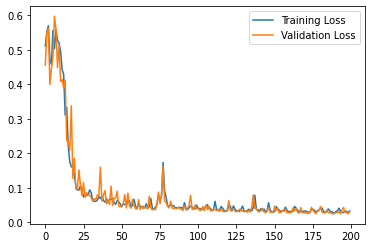

In [103]:
plot_training_history(history_a)

### 5.5.2. Real Data

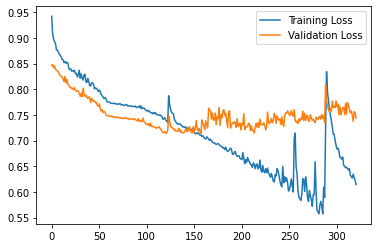

In [104]:
plot_training_history(history_r)

## 5.6. Anomaly Detection

In [105]:
def find_anomaly_threshold(model, x_train):
    # Get train MAE loss.
    x_train_pred = model.predict(x_train)
    diff = np.abs(x_train_pred - x_train)
    train_mae_loss = np.percentile(diff, axis=1, q=50)

    plt.hist(train_mae_loss, bins=50)
    plt.xlabel("Train MAE loss")
    plt.ylabel("No of samples")
    plt.show()

    # Get reconstruction loss threshold.    
    threshold = np.max(train_mae_loss)
    print("Reconstruction error threshold: ", threshold)
    return x_train_pred, threshold

### 5.6.1. Artificial Data

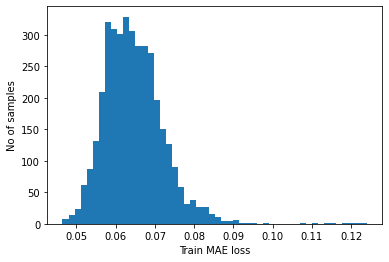

Reconstruction error threshold:  0.12399300806598634


In [106]:
x_train_pred_a, threshold_a = find_anomaly_threshold(model_a, x_train_a)

### 5.6.2. Real Data

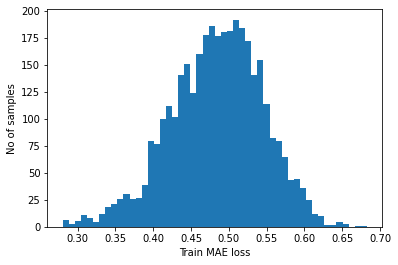

Reconstruction error threshold:  0.6826044994357043


In [107]:
x_train_pred_r, threshold_r = find_anomaly_threshold(model_r, x_train_r)

## 5.7. Compare Reconstruction

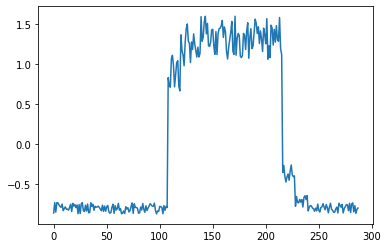

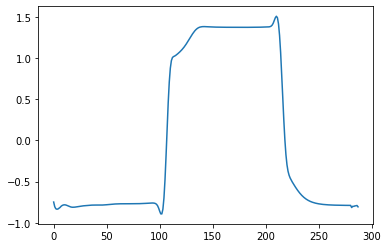

In [108]:
# Checking how the first sequence is learnt
plt.plot(x_train_a[0])
plt.show()
plt.plot(x_train_pred_a[0])
plt.show()

### 5.7.2. Real Data

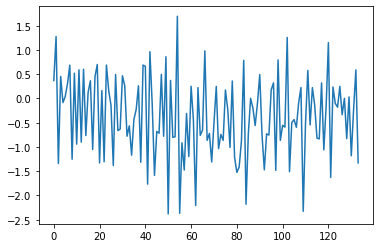

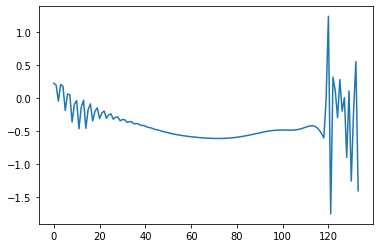

In [109]:
# Checking how the first sequence is learnt
plt.plot(x_train_r[0])
plt.show()
plt.plot(x_train_pred_r[0])
plt.show()

## 5.8. Prepare Test Data

In [110]:
def prepare_test_data(model, df, training_mean, training_std, threshold, time_steps):
    def normalize_test(values, mean, std):
        values -= mean
        values /= std
        return values

    test_values = get_values_from_df(df)
    test_values = normalize_test(test_values, training_mean, training_std)
    plt.plot(test_values.tolist())
    plt.show()

    # Create sequences from test values.
    x_test = create_sequences(test_values, time_steps)
    print("Test input shape: ", x_test.shape)

    # Get test MAE loss.
    x_test_pred = model.predict(x_test)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
    test_mae_loss = test_mae_loss.reshape((-1))

    plt.hist(test_mae_loss, bins=50)
    plt.xlabel("test MAE loss")
    plt.ylabel("No of samples")
    plt.show()

    # Detect all the samples which are anomalies.
    anomalies = (test_mae_loss > threshold).tolist()
#     print(test_mae_loss)
    print("Number of anomaly samples: ", np.sum(anomalies))
    print("Indices of anomaly samples: ", np.where(anomalies))
    return test_values, anomalies

### 5.8.1. Artificial Data

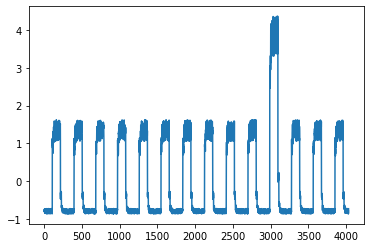

Test input shape:  (3744, 288, 1)


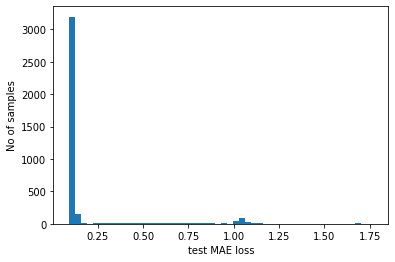

Number of anomaly samples:  525
Indices of anomaly samples:  (array([ 109,  110,  212,  213,  214,  215,  216,  219,  220,  221,  222,
        223,  397,  398,  399,  508,  509,  510,  685,  686,  770,  771,
        772,  773,  774,  775,  776,  777,  778,  779,  780,  781,  782,
        783,  784,  785,  786,  787,  788,  789,  790,  791,  792,  796,
        797,  798,  973,  974, 1086, 1087, 1261, 1262, 1371, 1372, 1373,
       1374, 1549, 1550, 1654, 1655, 1656, 1661, 1662, 1663, 1837, 1838,
       1924, 1925, 1927, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1939, 1940, 1941, 1942, 1943, 1944, 1947, 1948, 1949, 1950, 2125,
       2126, 2127, 2237, 2238, 2239, 2413, 2414, 2502, 2503, 2504, 2505,
       2506, 2507, 2508, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517,
       2518, 2519, 2520, 2521, 2524, 2525, 2526, 2527, 2701, 2702, 2703,
       2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714,
       2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2

In [111]:
test_values_a, anomalies_a = prepare_test_data(model_a, 
                                               df_daily_jumpsup, 
                                               training_mean_a, 
                                               training_std_a, 
                                               threshold_a, 
                                               time_steps=TIME_STEPS_A)

### 5.8.2. Real Data

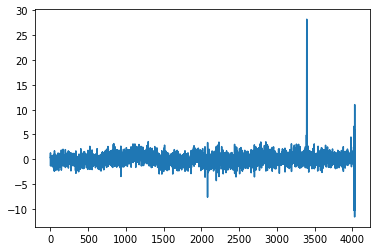

Test input shape:  (3898, 134, 1)


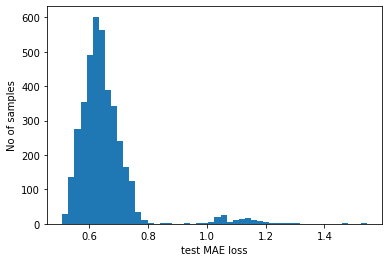

Number of anomaly samples:  909
Indices of anomaly samples:  (array([1196, 1197, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1214, 1219,
       1241, 1264, 1265, 1266, 1267, 1268, 1270, 1274, 1275, 1276, 1277,
       1278, 1279, 1280, 1281, 1282, 1284, 1285, 1287, 1288, 1289, 1291,
       1292, 1293, 1294, 1295, 1296, 1304, 1323, 1594, 1595, 1596, 1608,
       1932, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1957, 1960,
       1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2008, 2009, 2011, 2012, 2015, 2018, 2020, 2021, 2022,
       2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034,
       2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045,
       2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2

In [112]:
test_values_r, anomalies_r = prepare_test_data(model_r, 
                                               df_aws_latency_copy, 
                                               training_mean_r, 
                                               training_std_r, 
                                               threshold_r, 
                                               time_steps=TIME_STEPS_R)

## 5.9. Plot Anomalies

In [113]:
def plot_anomalies(data, anomalies, test_values, time_steps=100):
    anomalous_data_indices = []
    for data_idx in range(time_steps - 1, len(test_values) - time_steps + 1):
        time_series_idxs = range(data_idx - time_steps + 1, data_idx)
        if anomalies:
            chunk = []
            for j in time_series_idxs:
                if j < len(anomalies):
                    chunk.append(anomalies[j])
            if all(chunk):
                anomalous_data_indices.append(data_idx)
    df_subset = data.iloc[anomalous_data_indices, :]
    
    plt.figure(figsize=(20, 5))
    plt.subplots_adjust(bottom=0.2)
    plt.xticks(rotation=25)
    ax = plt.gca()
    xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
    ax.xaxis.set_major_formatter(xfmt)

    dates = data["timestamp"].to_list()
    dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
    values = data["value"].to_list()
    plt.plot(dates, values, label="test data")

    dates_anomalies = df_subset["timestamp"].to_list()
    dates_anomalies = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates_anomalies]
    values_anomalies = df_subset["value"].to_list()
    plt.plot(dates_anomalies, values_anomalies, label="anomalies", color="red", marker='o', linestyle='')

    plt.legend()
    plt.show()

### 5.9.1. Artificial Data

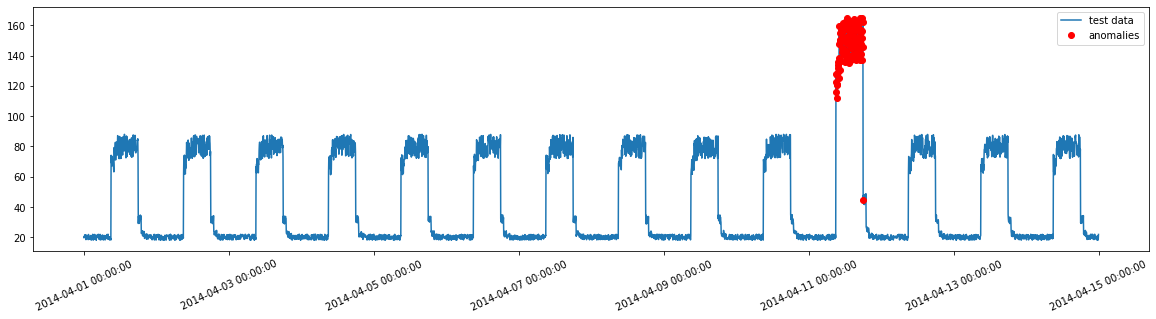

In [114]:
plot_anomalies(df_daily_jumpsup, anomalies_a, test_values_a, time_steps=TIME_STEPS_A)

### 5.9.2. Real Data

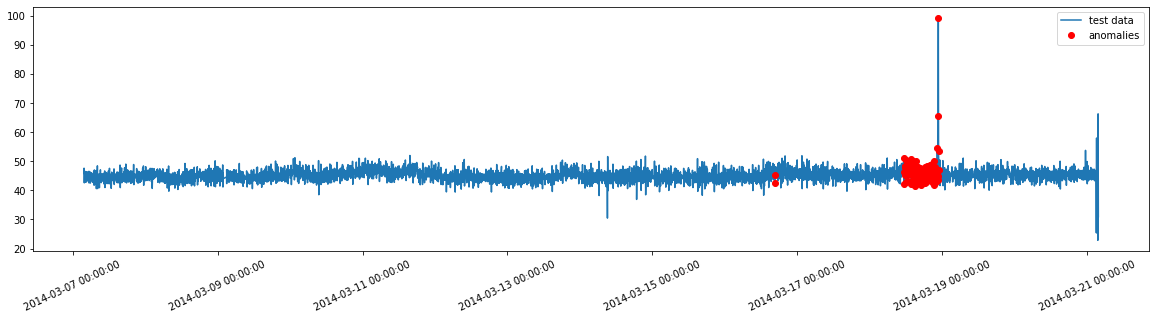

In [115]:
plot_anomalies(df_aws_latency_copy, anomalies_r, test_values_r, time_steps=120)

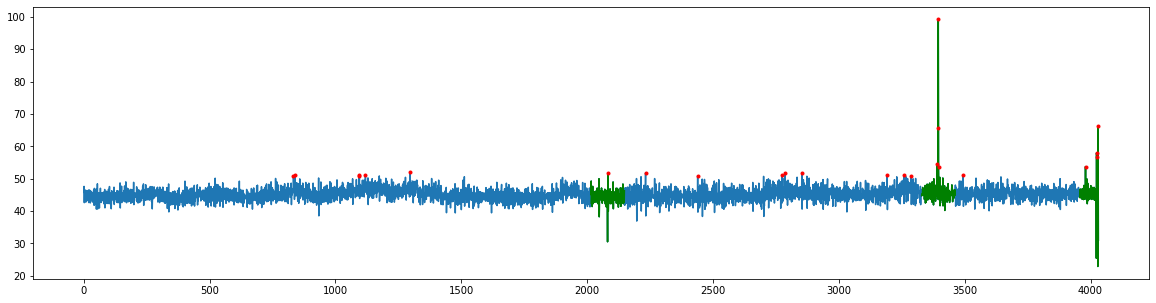

In [116]:
fig, ax = plt.subplots()

ax = df_aws_latency_copy.value.plot(figsize=(20,5))
ax = df_aws_latency_copy.loc[mask_aws_latency_anomaly1].value.plot(figsize=(20,5), color='green')
ax = df_aws_latency_copy.loc[mask_aws_latency_anomaly2].value.plot(figsize=(20,5), color='green')
ax = df_aws_latency_copy.loc[mask_aws_latency_anomaly3].value.plot(figsize=(20,5), color='green')
ax = anomalies_z_r.loc[anomalies_z_r_mask].value.plot(figsize=(20,5), color='red', marker='.', linestyle='none')

# plt.legend(loc='best')
plt.show()